In [1]:
import dolfin as df 
from dolfin import *
import numpy as np
import os
from pymedit import (
    P1Function,
    square,
    mmg2d,
    trunc,
)

hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


In [2]:
from scar.utils import read_config,create_tree,get_class
from scar.equations.run_EikonalLap2D import *
from scar.geometry import Geometry2D
from scar.geometry.StandardMesh import *
import torch
import dolfin as df
from dolfin import FunctionSpace,Function

import matplotlib.pyplot as plt

Using device: cuda
cuda devices:        1
cuda current device: 0
cuda device name:    NVIDIA RTX 2000 Ada Generation Laptop GPU
torch loaded; device is cuda


## Récupération de la Levelset

In [3]:
form_name = "Bean"
num_config = 3
sdf_run = run_EikonalLap2D

In [4]:
dir_name = "../../networks/EikonalLap2D/"+form_name+"/"
models_dir = dir_name+"models/"
config_filename = models_dir+"config_"+str(num_config)+".json"
model_filename = models_dir+"model_"+str(num_config)+".pth"
derivees_dir = dir_name+"derivees/"
create_tree(derivees_dir)

In [5]:
geom_class = get_class(form_name,Geometry2D)
form = geom_class()

bc_points.shape = (2000, 2), bc_normals.shape = (2000, 2)
ICIIIII : tv_loss_f =  MSELoss()
>> load network /home/flecourtier/Bureau/Thèse/networks/EikonalLap2D/Bean/models/model_3.pth
norm_grad_norm_gradu : torch.Size([20000, 1])
norm_grad_norm_gradu : torch.Size([20000, 1])


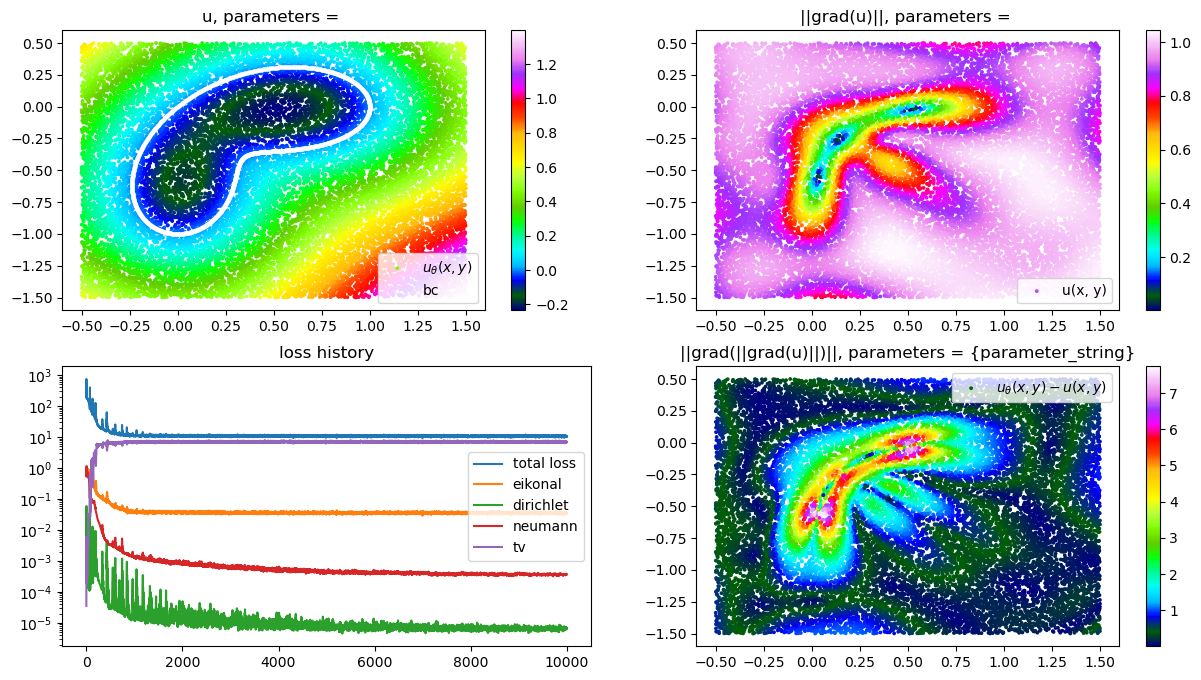

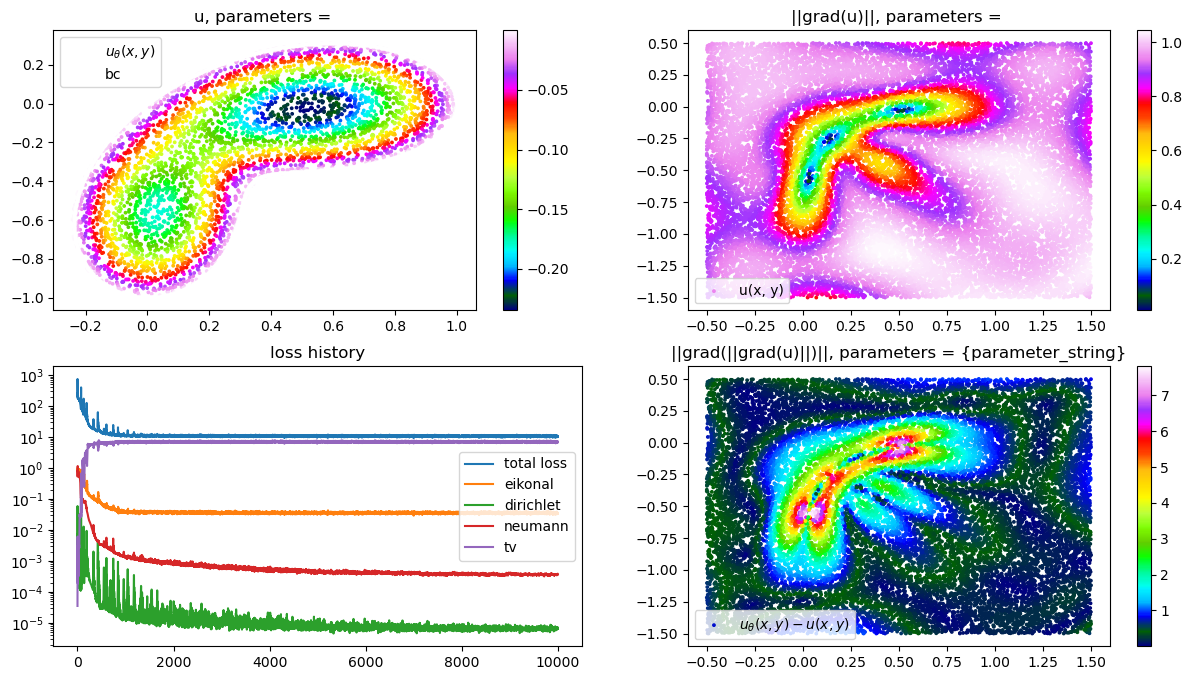

In [6]:
dict_config = read_config(config_filename)
eik,trainer = sdf_run(form,num_config,dict_config,new_training = False,createxyzfile=False)

## Construction du maillage standard

In [7]:
mesh_dir = dir_name + "meshes/"
if not os.path.exists(mesh_dir):
    os.makedirs(mesh_dir)
mesh = overrefined_mesh(form,trainer,mesh_dir,n=101,hmin=0.001,hmax=0.005)

mmg2d_O3 -nr -hmin 0.001 -hmax 0.005 -hausd 0.0001 -ls -sol /tmp/tmp6ghhrqct/Th.solb /tmp/tmp6ghhrqct/Th.meshb


  -- MMG2D, Release 5.7.0 (Dec. 13, 2022) 
     Copyright (c) Bdx INP/CNRS/Inria/UPMC, 2004-
     Mar 12 2024 16:58:31

  -- INPUT DATA
  %% /tmp/tmp6ghhrqct/Th.meshb OPENED
  %% /tmp/tmp6ghhrqct/Th.solb OPENED
  -- DATA READING COMPLETED.     0.005s

  &&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&
   MODULE MMG2D: 5.7.0 (Dec. 13, 2022)
  &&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&
     git branch: master
     git commit: b8995360a4c5b894949c08b1bba90750a2062a7a
     git date:   2024-01-30 11:43:38 +0100


  -- MMG2DLS: INPUT DATA
  --  INPUT DATA COMPLETED.     0.000s

  -- PHASE 1 : ISOSURFACE DISCRETIZATION

  -- MESH QUALITY   20000
     BEST   0.866025  AVRG.   0.866025  WRST.   0.866025 (7)
     HISTOGRAMM:  100.00 % > 0.12
  *** Manifold implicit surface.
  -- PHASE 1 COMPLETED.     0.004s

  -- PHASE 2 : ANALYSIS
  -- PHASE 2 COMPLETED.     0.001s

  -- PHASE 3 : MESH IMPROVEMENT
       100929 splitted,      332 collapsed,    10704 swapped, 5 ite

discarding line.


## Show boundary

In [8]:
approach_bc = get_boundary_vertices(mesh)
exact_bc = eik.bc_points.cpu().detach().numpy()

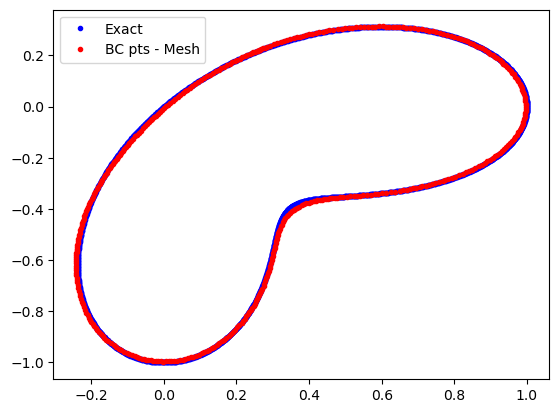

In [9]:
plt.figure()
plt.plot(exact_bc[:,0],exact_bc[:,1],'b.',label="Exact")
plt.plot(approach_bc[:,0],approach_bc[:,1],'r.',label="BC pts - Mesh")
plt.legend()
plt.show()

In [13]:
parameter_domain = trainer.pde.parameter_domain
X_test,mu_test = create_test_sample(approach_bc,parameter_domain)
pred = trainer.network.setup_w_dict(X_test, mu_test)
phi = pred["w"][:,0].cpu().detach().numpy()

In [14]:
np.mean(np.abs(phi))

7.00966001114047e-05

## Convergence

In [13]:
tab_n = [20*i+1 for i in range(1,11)]
bc_error = []
for n in tab_n:
    parameter_domain = trainer.pde.parameter_domain
    XY = get_XY(form.bound_box,n)
    X_test,mu_test = create_test_sample(XY,parameter_domain)
    M,phiP1 = get_levelset(trainer,X_test,mu_test,n)

    hmin,hmax = 0.01,0.05
    filename = "levelset_mesh/"+form_name+"_"+str(n)
    if not os.path.exists(filename+".xml"):
        construct_mesh(M,phiP1,hmin,hmax,filename)
    mesh = get_df_mesh(form.bound_box,filename)

    approach_bc = get_boundary_vertices(mesh)
    exact_bc = eik.bc_points.cpu().detach().numpy()

    X_test,mu_test = create_test_sample(approach_bc,parameter_domain)
    pred = trainer.network.setup_w_dict(X_test, mu_test)
    phi = pred["w"][:,0].cpu().detach().numpy()

    bc_error.append(np.mean(np.abs(phi)))

mmg2d_O3 -nr -hmin 0.01 -hmax 0.05 -hausd 0.001 -ls -sol /tmp/tmp7ib20bbz/Th.solb /tmp/tmp7ib20bbz/Th.meshb


  -- MMG2D, Release 5.7.0 (Dec. 13, 2022) 
     Copyright (c) Bdx INP/CNRS/Inria/UPMC, 2004-
     Mar 12 2024 16:58:31

  -- INPUT DATA
  %% /tmp/tmp7ib20bbz/Th.meshb OPENED
  %% /tmp/tmp7ib20bbz/Th.solb OPENED
  -- DATA READING COMPLETED.     0.002s

  &&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&
   MODULE MMG2D: 5.7.0 (Dec. 13, 2022)
  &&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&
     git branch: master
     git commit: b8995360a4c5b894949c08b1bba90750a2062a7a
     git date:   2024-01-30 11:43:38 +0100


  -- MMG2DLS: INPUT DATA
  --  INPUT DATA COMPLETED.     0.000s

  -- PHASE 1 : ISOSURFACE DISCRETIZATION

  -- MESH QUALITY   800
     BEST   0.866025  AVRG.   0.866025  WRST.   0.866025 (3)
     HISTOGRAMM:  100.00 % > 0.12
  *** Manifold implicit surface.
  -- PHASE 1 COMPLETED.     0.000s

  -- PHASE 2 : ANALYSIS
  -- PHASE 2 COMPLETED.     0.000s

  -- PHASE 3 : MESH IMPROVEMENT
          905 splitted,       31 collapsed,      363 swapped, 3 iter.

discarding line.
discarding line.



Finished in (0.03s)
Truncating mesh from region 3
Reading mesh from file
mmg2d_O3 -nr -hmin 0.01 -hmax 0.05 -hausd 0.001 -ls -sol /tmp/tmplx5w_tya/Th.solb /tmp/tmplx5w_tya/Th.meshb
  -- MMG2D, Release 5.7.0 (Dec. 13, 2022) 
     Copyright (c) Bdx INP/CNRS/Inria/UPMC, 2004-
     Mar 12 2024 16:58:31

  -- INPUT DATA
  %% /tmp/tmplx5w_tya/Th.meshb OPENED
  %% /tmp/tmplx5w_tya/Th.solb OPENED
  -- DATA READING COMPLETED.     0.003s

  &&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&
   MODULE MMG2D: 5.7.0 (Dec. 13, 2022)
  &&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&
     git branch: master
     git commit: b8995360a4c5b894949c08b1bba90750a2062a7a
     git date:   2024-01-30 11:43:38 +0100


  -- MMG2DLS: INPUT DATA
  --  INPUT DATA COMPLETED.     0.000s

  -- PHASE 1 : ISOSURFACE DISCRETIZATION

  -- MESH QUALITY   12800
     BEST   0.866025  AVRG.   0.866025  WRST.   0.866025 (3)
     HISTOGRAMM:  100.00 % > 0.12
  *** Manifold implicit surface.
  -- PHASE 1 

discarding line.
discarding line.


  -- MMG2D, Release 5.7.0 (Dec. 13, 2022) 
     Copyright (c) Bdx INP/CNRS/Inria/UPMC, 2004-
     Mar 12 2024 16:58:31

  -- INPUT DATA
  %% /tmp/tmpkot1dm_z/Th.meshb OPENED
  %% /tmp/tmpkot1dm_z/Th.solb OPENED
  -- DATA READING COMPLETED.     0.004s

  &&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&
   MODULE MMG2D: 5.7.0 (Dec. 13, 2022)
  &&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&
     git branch: master
     git commit: b8995360a4c5b894949c08b1bba90750a2062a7a
     git date:   2024-01-30 11:43:38 +0100


  -- MMG2DLS: INPUT DATA
  --  INPUT DATA COMPLETED.     0.000s

  -- PHASE 1 : ISOSURFACE DISCRETIZATION

  -- MESH QUALITY   20000
     BEST   0.866025  AVRG.   0.866025  WRST.   0.866025 (7)
     HISTOGRAMM:  100.00 % > 0.12
  *** Manifold implicit surface.
  -- PHASE 1 COMPLETED.     0.003s

  -- PHASE 2 : ANALYSIS
  -- PHASE 2 COMPLETED.     0.000s

  -- PHASE 3 : MESH IMPROVEMENT
            4 splitted,     3763 collapsed,      261 swapped, 3 ite

discarding line.
discarding line.


Reading mesh from file
mmg2d_O3 -nr -hmin 0.01 -hmax 0.05 -hausd 0.001 -ls -sol /tmp/tmpf57fkrj4/Th.solb /tmp/tmpf57fkrj4/Th.meshb
  -- MMG2D, Release 5.7.0 (Dec. 13, 2022) 
     Copyright (c) Bdx INP/CNRS/Inria/UPMC, 2004-
     Mar 12 2024 16:58:31

  -- INPUT DATA
  %% /tmp/tmpf57fkrj4/Th.meshb OPENED
  %% /tmp/tmpf57fkrj4/Th.solb OPENED
  -- DATA READING COMPLETED.     0.005s

  &&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&
   MODULE MMG2D: 5.7.0 (Dec. 13, 2022)
  &&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&
     git branch: master
     git commit: b8995360a4c5b894949c08b1bba90750a2062a7a
     git date:   2024-01-30 11:43:38 +0100


  -- MMG2DLS: INPUT DATA
  --  INPUT DATA COMPLETED.     0.000s

  -- PHASE 1 : ISOSURFACE DISCRETIZATION

  -- MESH QUALITY   39200
     BEST   0.866025  AVRG.   0.866025  WRST.   0.866025 (707)
     HISTOGRAMM:  100.00 % > 0.12
  *** Manifold implicit surface.
  -- PHASE 1 COMPLETED.     0.004s

  -- PHASE 2 : ANALYSIS
  

discarding line.


Reading mesh from file
mmg2d_O3 -nr -hmin 0.01 -hmax 0.05 -hausd 0.001 -ls -sol /tmp/tmp_8mibsgl/Th.solb /tmp/tmp_8mibsgl/Th.meshb
  -- MMG2D, Release 5.7.0 (Dec. 13, 2022) 
     Copyright (c) Bdx INP/CNRS/Inria/UPMC, 2004-
     Mar 12 2024 16:58:31

  -- INPUT DATA
  %% /tmp/tmp_8mibsgl/Th.meshb OPENED
  %% /tmp/tmp_8mibsgl/Th.solb OPENED
  -- DATA READING COMPLETED.     0.008s

  &&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&
   MODULE MMG2D: 5.7.0 (Dec. 13, 2022)
  &&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&
     git branch: master
     git commit: b8995360a4c5b894949c08b1bba90750a2062a7a
     git date:   2024-01-30 11:43:38 +0100


  -- MMG2DLS: INPUT DATA
  --  INPUT DATA COMPLETED.     0.000s

  -- PHASE 1 : ISOSURFACE DISCRETIZATION

  -- MESH QUALITY   64800
     BEST   0.866025  AVRG.   0.866025  WRST.   0.866025 (364)
     HISTOGRAMM:  100.00 % > 0.12
  *** Manifold implicit surface.
  -- PHASE 1 COMPLETED.     0.010s

  -- PHASE 2 : ANALYSIS
  

discarding line.


Reading mesh from file
mmg2d_O3 -nr -hmin 0.01 -hmax 0.05 -hausd 0.001 -ls -sol /tmp/tmpd_5jajv7/Th.solb /tmp/tmpd_5jajv7/Th.meshb
  -- MMG2D, Release 5.7.0 (Dec. 13, 2022) 
     Copyright (c) Bdx INP/CNRS/Inria/UPMC, 2004-
     Mar 12 2024 16:58:31

  -- INPUT DATA
  %% /tmp/tmpd_5jajv7/Th.meshb OPENED
  %% /tmp/tmpd_5jajv7/Th.solb OPENED
  -- DATA READING COMPLETED.     0.009s

  &&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&
   MODULE MMG2D: 5.7.0 (Dec. 13, 2022)
  &&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&
     git branch: master
     git commit: b8995360a4c5b894949c08b1bba90750a2062a7a
     git date:   2024-01-30 11:43:38 +0100


  -- MMG2DLS: INPUT DATA
  --  INPUT DATA COMPLETED.     0.000s

  -- PHASE 1 : ISOSURFACE DISCRETIZATION

  -- MESH QUALITY   80000
     BEST   0.866025  AVRG.   0.866025  WRST.   0.866025 (7)
     HISTOGRAMM:  100.00 % > 0.12
  *** Manifold implicit surface.
  -- PHASE 1 COMPLETED.     0.010s

  -- PHASE 2 : ANALYSIS
  --

discarding line.


Reading mesh from file


discarding line.


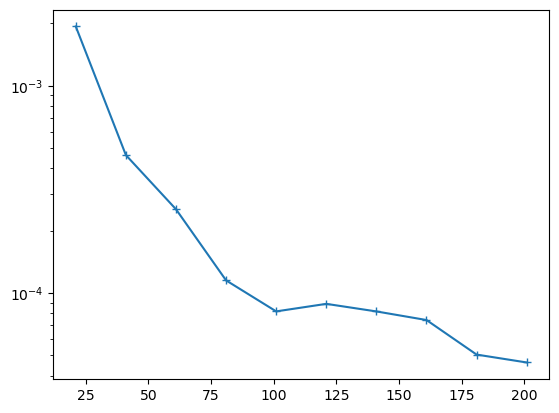

In [14]:
plt.figure()
plt.semilogy(tab_n,bc_error,"+-")
plt.show()

In [15]:
tab_n = [20*i+1 for i in range(1,11)]
bc_error = []
for n in tab_n:
    parameter_domain = trainer.pde.parameter_domain
    XY = get_XY(form.bound_box,n)
    X_test,mu_test = create_test_sample(XY,parameter_domain)
    M,phiP1 = get_levelset(trainer,X_test,mu_test,n)

    hmin,hmax = 0.001,0.005
    filename = "levelset_mesh/"+form_name+"_"+str(n)+"_2"
    if not os.path.exists(filename+".xml"):
        construct_mesh(M,phiP1,hmin,hmax,filename)
    mesh = get_df_mesh(form.bound_box,filename)

    approach_bc = get_boundary_vertices(mesh)
    exact_bc = eik.bc_points.cpu().detach().numpy()

    X_test,mu_test = create_test_sample(approach_bc,parameter_domain)
    pred = trainer.network.setup_w_dict(X_test, mu_test)
    phi = pred["w"][:,0].cpu().detach().numpy()

    bc_error.append(np.mean(np.abs(phi)))

mmg2d_O3 -nr -hmin 0.001 -hmax 0.005 -hausd 0.0001 -ls -sol /tmp/tmp8e6lb30k/Th.solb /tmp/tmp8e6lb30k/Th.meshb
  -- MMG2D, Release 5.7.0 (Dec. 13, 2022) 
     Copyright (c) Bdx INP/CNRS/Inria/UPMC, 2004-
     Mar 12 2024 16:58:31

  -- INPUT DATA
  %% /tmp/tmp8e6lb30k/Th.meshb OPENED
  %% /tmp/tmp8e6lb30k/Th.solb OPENED
  -- DATA READING COMPLETED.     0.002s

  &&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&
   MODULE MMG2D: 5.7.0 (Dec. 13, 2022)
  &&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&
     git branch: master
     git commit: b8995360a4c5b894949c08b1bba90750a2062a7a
     git date:   2024-01-30 11:43:38 +0100


  -- MMG2DLS: INPUT DATA
  --  INPUT DATA COMPLETED.     0.000s

  -- PHASE 1 : ISOSURFACE DISCRETIZATION

  -- MESH QUALITY   800
     BEST   0.866025  AVRG.   0.866025  WRST.   0.866025 (3)
     HISTOGRAMM:  100.00 % > 0.12
  *** Manifold implicit surface.
  -- PHASE 1 COMPLETED.     0.000s

  -- PHASE 2 : ANALYSIS
  -- PHASE 2 COMPLETED.   

discarding line.


        69891 splitted,      556 collapsed,     2640 swapped, 5 iter.

  -- GRADATION : 1.300000 (2.300000)
            0 splitted,      355 collapsed,      173 swapped, 2 iter.
        16721 splitted,    74378 collapsed,    19862 swapped,   227248 moved, 4 iter. 
  -- PHASE 3 COMPLETED.     0.486s

  -- MESH QUALITY   91675
     BEST   0.999999  AVRG.   0.962881  WRST.   0.602421 (81418)
     HISTOGRAMM:  100.00 % > 0.12

  -- MESH PACKED UP
     NUMBER OF VERTICES          46198   CORNERS        4
     NUMBER OF TRIANGLES         91675
     NUMBER OF EDGES              1171

   MMG2DLS: ELAPSED TIME  0.494s

  &&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&
   END OF MODULE MMG2D
  &&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&


  -- WRITING DATA FILE /tmp/tmpkp611_ul/Th.o.meshb
  %% /tmp/tmpkp611_ul/Th.o.meshb OPENED
  %% /tmp/tmpkp611_ul/Th.o.sol OPENED
  -- WRITING COMPLETED

   ELAPSED TIME  0.510s

Finished in (0.53s)
Truncating mesh from region 3
Rea

discarding line.


       150239 splitted,      359 collapsed,     2716 swapped, 5 iter.

  -- GRADATION : 1.300000 (2.300000)
           32 splitted,      187 collapsed,      105 swapped, 2 iter.
         1067 splitted,    75494 collapsed,     8658 swapped,   213545 moved, 4 iter. 
  -- PHASE 3 COMPLETED.     0.427s

  -- MESH QUALITY   81564
     BEST   1.000000  AVRG.   0.958907  WRST.   0.612534 (4249)
     HISTOGRAMM:  100.00 % > 0.12

  -- MESH PACKED UP
     NUMBER OF VERTICES          41243   CORNERS        4
     NUMBER OF TRIANGLES         81564
     NUMBER OF EDGES              1380

   MMG2DLS: ELAPSED TIME  0.435s

  &&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&
   END OF MODULE MMG2D
  &&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&


  -- WRITING DATA FILE /tmp/tmpz7opcisr/Th.o.meshb
  %% /tmp/tmpz7opcisr/Th.o.meshb OPENED
  %% /tmp/tmpz7opcisr/Th.o.sol OPENED
  -- WRITING COMPLETED

   ELAPSED TIME  0.451s

Finished in (0.47s)
Truncating mesh from region 3
Read

discarding line.


        65400 splitted,      428 collapsed,     2071 swapped, 4 iter.

  -- GRADATION : 1.300000 (2.300000)
           12 splitted,      189 collapsed,      104 swapped, 3 iter.
         8417 splitted,    72086 collapsed,     2865 swapped,   193012 moved, 4 iter. 
  -- PHASE 3 COMPLETED.     0.427s

  -- MESH QUALITY   78989
     BEST   0.999997  AVRG.   0.921356  WRST.   0.644003 (12435)
     HISTOGRAMM:  100.00 % > 0.12

  -- MESH PACKED UP
     NUMBER OF VERTICES          39839   CORNERS        4
     NUMBER OF TRIANGLES         78989
     NUMBER OF EDGES              1138

   MMG2DLS: ELAPSED TIME  0.436s

  &&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&
   END OF MODULE MMG2D
  &&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&


  -- WRITING DATA FILE /tmp/tmpww2pf5pk/Th.o.meshb
  %% /tmp/tmpww2pf5pk/Th.o.meshb OPENED
  %% /tmp/tmpww2pf5pk/Th.o.sol OPENED
  -- WRITING COMPLETED

   ELAPSED TIME  0.452s

Finished in (0.47s)
Truncating mesh from region 3
Rea

discarding line.


       100929 splitted,      332 collapsed,    10704 swapped, 5 iter.

  -- GRADATION : 1.300000 (2.300000)
           14 splitted,      207 collapsed,      125 swapped, 3 iter.
        12343 splitted,   117998 collapsed,    13561 swapped,   221584 moved, 5 iter. 
  -- PHASE 3 COMPLETED.     0.747s

  -- MESH QUALITY   89410
     BEST   1.000000  AVRG.   0.955279  WRST.   0.668560 (64966)
     HISTOGRAMM:  100.00 % > 0.12

  -- MESH PACKED UP
     NUMBER OF VERTICES          45104   CORNERS        4
     NUMBER OF TRIANGLES         89410
     NUMBER OF EDGES              1234

   MMG2DLS: ELAPSED TIME  0.761s

  &&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&
   END OF MODULE MMG2D
  &&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&


  -- WRITING DATA FILE /tmp/tmpu_wkhkll/Th.o.meshb
  %% /tmp/tmpu_wkhkll/Th.o.meshb OPENED
  %% /tmp/tmpu_wkhkll/Th.o.sol OPENED
  -- WRITING COMPLETED

   ELAPSED TIME  0.780s

Finished in (0.80s)
Truncating mesh from region 3
Rea

discarding line.


       143500 splitted,      260 collapsed,     2105 swapped, 4 iter.

  -- GRADATION : 1.300000 (2.300000)
           23 splitted,      124 collapsed,       81 swapped, 3 iter.
          692 splitted,    72182 collapsed,     2275 swapped,   223118 moved, 4 iter. 
  -- PHASE 3 COMPLETED.     0.467s

  -- MESH QUALITY   87760
     BEST   0.999996  AVRG.   0.878755  WRST.   0.584991 (43449)
     HISTOGRAMM:  100.00 % > 0.12

  -- MESH PACKED UP
     NUMBER OF VERTICES          44340   CORNERS        4
     NUMBER OF TRIANGLES         87760
     NUMBER OF EDGES              1366

   MMG2DLS: ELAPSED TIME  0.483s

  &&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&
   END OF MODULE MMG2D
  &&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&


  -- WRITING DATA FILE /tmp/tmp7_4za9sk/Th.o.meshb
  %% /tmp/tmp7_4za9sk/Th.o.meshb OPENED
  %% /tmp/tmp7_4za9sk/Th.o.sol OPENED
  -- WRITING COMPLETED

   ELAPSED TIME  0.502s

Finished in (0.52s)
Truncating mesh from region 3
Rea

discarding line.


       194351 splitted,      317 collapsed,     1411 swapped, 4 iter.

  -- GRADATION : 1.300000 (2.300000)
            7 splitted,      121 collapsed,       67 swapped, 2 iter.
         1891 splitted,    88732 collapsed,    44855 swapped,   372772 moved, 5 iter. 
  -- PHASE 3 COMPLETED.     0.677s

  -- MESH QUALITY   138992
     BEST   0.999999  AVRG.   0.886136  WRST.   0.642684 (336)
     HISTOGRAMM:  100.00 % > 0.12

  -- MESH PACKED UP
     NUMBER OF VERTICES          69999   CORNERS        4
     NUMBER OF TRIANGLES        138992
     NUMBER OF EDGES              1436

   MMG2DLS: ELAPSED TIME  0.692s

  &&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&
   END OF MODULE MMG2D
  &&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&


  -- WRITING DATA FILE /tmp/tmpp_rn4r7x/Th.o.meshb
  %% /tmp/tmpp_rn4r7x/Th.o.meshb OPENED
  %% /tmp/tmpp_rn4r7x/Th.o.sol OPENED
  -- WRITING COMPLETED

   ELAPSED TIME  0.718s

Finished in (0.74s)
Truncating mesh from region 3


discarding line.


Reading mesh from file
mmg2d_O3 -nr -hmin 0.001 -hmax 0.005 -hausd 0.0001 -ls -sol /tmp/tmpip9gwsfv/Th.solb /tmp/tmpip9gwsfv/Th.meshb
  -- MMG2D, Release 5.7.0 (Dec. 13, 2022) 
     Copyright (c) Bdx INP/CNRS/Inria/UPMC, 2004-
     Mar 12 2024 16:58:31

  -- INPUT DATA
  %% /tmp/tmpip9gwsfv/Th.meshb OPENED
  %% /tmp/tmpip9gwsfv/Th.solb OPENED
  -- DATA READING COMPLETED.     0.006s

  &&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&
   MODULE MMG2D: 5.7.0 (Dec. 13, 2022)
  &&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&
     git branch: master
     git commit: b8995360a4c5b894949c08b1bba90750a2062a7a
     git date:   2024-01-30 11:43:38 +0100


  -- MMG2DLS: INPUT DATA
  --  INPUT DATA COMPLETED.     0.000s

  -- PHASE 1 : ISOSURFACE DISCRETIZATION

  -- MESH QUALITY   51200
     BEST   0.866025  AVRG.   0.866025  WRST.   0.866025 (3)
     HISTOGRAMM:  100.00 % > 0.12
  *** Manifold implicit surface.
  -- PHASE 1 COMPLETED.     0.009s

  -- PHASE 2 : ANALYSIS
 

discarding line.


        65524 splitted,      431 collapsed,     1119 swapped, 3 iter.

  -- GRADATION : 1.300000 (2.300000)
            0 splitted,      133 collapsed,       80 swapped, 3 iter.
        10218 splitted,    83227 collapsed,    17696 swapped,   293946 moved, 5 iter. 
  -- PHASE 3 COMPLETED.     0.564s

  -- MESH QUALITY   114732
     BEST   0.999997  AVRG.   0.895414  WRST.   0.000056 (108633)
     HISTOGRAMM:   99.95 % > 0.12

  -- MESH PACKED UP
     NUMBER OF VERTICES          57650   CORNERS        4
     NUMBER OF TRIANGLES        114732
     NUMBER OF EDGES               978

   MMG2DLS: ELAPSED TIME  0.585s

  &&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&
   END OF MODULE MMG2D
  &&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&


  -- WRITING DATA FILE /tmp/tmp092ztwz6/Th.o.meshb
  %% /tmp/tmp092ztwz6/Th.o.meshb OPENED
  %% /tmp/tmp092ztwz6/Th.o.sol OPENED
  -- WRITING COMPLETED

   ELAPSED TIME  0.614s

Finished in (0.64s)
Truncating mesh from region 3
R

discarding line.


  %% /tmp/tmpm5ppkh2m/Th.solb OPENED
  -- DATA READING COMPLETED.     0.017s

  &&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&
   MODULE MMG2D: 5.7.0 (Dec. 13, 2022)
  &&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&
     git branch: master
     git commit: b8995360a4c5b894949c08b1bba90750a2062a7a
     git date:   2024-01-30 11:43:38 +0100


  -- MMG2DLS: INPUT DATA
  --  INPUT DATA COMPLETED.     0.000s

  -- PHASE 1 : ISOSURFACE DISCRETIZATION

  -- MESH QUALITY   80000
     BEST   0.866025  AVRG.   0.866025  WRST.   0.866025 (7)
     HISTOGRAMM:  100.00 % > 0.12
  *** Manifold implicit surface.
  -- PHASE 1 COMPLETED.     0.012s

  -- PHASE 2 : ANALYSIS
  -- PHASE 2 COMPLETED.     0.002s

  -- PHASE 3 : MESH IMPROVEMENT
        80660 splitted,      361 collapsed,     9678 swapped, 4 iter.

  -- GRADATION : 1.300000 (2.300000)
           19 splitted,      199 collapsed,      117 swapped, 3 iter.
        26587 splitted,   131408 collapsed,    16692 swapped,  

discarding line.


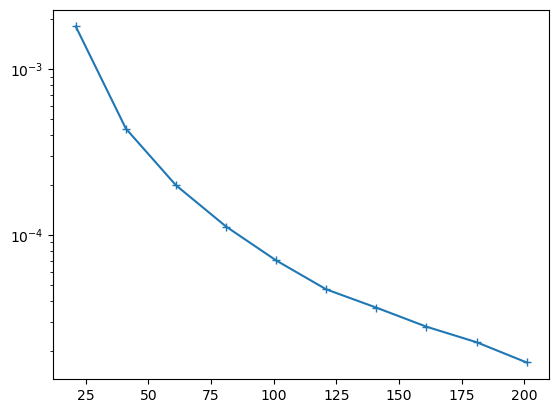

In [16]:
plt.figure()
plt.semilogy(tab_n,bc_error,"+-")
plt.show()
